## Setup

In [54]:
import re
import json
import pickle
import os
import sys
import requests
import logging
import torch
from tqdm.auto import tqdm
from transformer_lens import HookedTransformer
from tqdm.auto import tqdm
import plotly.io as pio
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import wandb
import plotly.express as px
import pandas as pd
import torch.nn.init as init
from pathlib import Path
from jaxtyping import Int, Float
from torch import Tensor
import einops
from collections import Counter
from datasets import load_dataset
import pandas as pd
from ipywidgets import interact, IntSlider
from process_tiny_stories_data import load_tinystories_validation_prompts, load_tinystories_tokens
from typing import Literal
from transformer_lens.utils import test_prompt
import pickle
from ipywidgets import interact, IntSlider, SelectionSlider
from transformer_lens.utils import test_prompt

import plotly.graph_objects as go

pio.renderers.default = "notebook_connected"
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
torch.autograd.set_grad_enabled(False)
torch.set_grad_enabled(False)

logging.basicConfig(format='(%(levelname)s) %(asctime)s: %(message)s', level=logging.INFO, datefmt='%I:%M:%S')
sys.path.append('../')  # Add the parent directory to the system path

import utils.haystack_utils as haystack_utils
from sparse_coding.train_autoencoder import AutoEncoder
from utils.autoencoder_utils import AutoEncoderConfig, get_loss_recovered, get_l0, get_feature_density, train_autoencoder_evaluate_autoencoder_reconstruction, evaluate_autoencoder_reconstruction, eval_direction_tokens_global, get_activations, get_acts, load_encoder, eval_ablation_token_rank, get_direction_ablation_hook, get_top_activating_examples_for_direction, evaluate_direction_ablation_single_prompt
import utils.haystack_utils as haystack_utils
from utils.plotting_utils import line, multiple_line, plot_square_heatmap
%reload_ext autoreload
%autoreload 2

In [2]:
model_name = "tiny-stories-2L-33M"
model = HookedTransformer.from_pretrained(
    model_name,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    device=device,
)
model.set_use_attn_result(True)
prompts = load_tinystories_validation_prompts()

Loaded pretrained model tiny-stories-2L-33M into HookedTransformer


(INFO) 09:45:53: Loaded 21990 TinyStories validation prompts


In [3]:
# Models

# L0
# 54_serene_plasma
# 52_polar_river
# 47_polar_thunder


# L1
# 186_earthy_moon 75%, 55.2
# 185_upbeat_field 73%, 35.8
# 154_electric_feather 74%, 42.5
# 98_hardy_firefly 60%, 34.3

In [66]:
run_name = "154_electric_feather" # "98_hardy_firefly"#
encoder, cfg = load_encoder(run_name, model_name, model)
cfg.run_name = run_name
print(cfg.run_name, cfg.layer, cfg.l1_coeff)

154_electric_feather 1 0.00035


In [67]:
# run_name = cfg.run_name
# max_activations, max_activation_token_indices = get_activations(encoder, cfg, run_name, prompts, model, save_activations=True)

In [78]:
def eval_model(run_name):
    encoder, cfg = load_encoder(run_name, model_name, model)
    cfg.run_name = run_name
    loss_recovered = get_loss_recovered(prompts[:200], model, encoder, cfg, disable_tqdm=True)
    l0 = get_l0(prompts[:200], model, encoder, cfg, disable_tqdm=True)
    feature_density = get_feature_density(prompts[:1000], model, encoder, cfg, disable_tqdm=True)
    low_density = (feature_density < 1e-5).sum().item() / encoder.d_hidden
    data = [run_name, cfg.layer, cfg.l1_coeff, cfg.reg, loss_recovered, l0, low_density]
    df = pd.DataFrame([data], columns=["run_name", "layer", "l1_coeff", "regularization", "loss_recovered", "l0", "feature_density"])
    return df

In [79]:
l1_models = ["186_earthy_moon", "185_upbeat_field", "154_electric_feather"]
l1_dfs = [eval_model(run_name) for run_name in l1_models]
l1_df = pd.concat(l1_dfs)
l1_df.head()

run_name  layer  l1_coeff regularization  loss_recovered  \
0       186_earthy_moon      1   0.00030             l1        0.743836   
0      185_upbeat_field      1   0.00040             l1        0.717516   
0  154_electric_feather      1   0.00035             l1        0.730587   

          l0  feature_density  
0  54.104745         0.000122  
0  35.006945         0.000366  
0  41.643603         0.000244

In [81]:
l0_models = ["54_serene_plasma", "52_polar_river", "47_polar_thunder"]
l0_dfs = [eval_model(run_name) for run_name in l0_models]
l0_df = pd.concat(l0_dfs)
l0_df.head()

run_name  layer        l1_coeff       regularization  \
0  54_serene_plasma      0          0.0003                   l1   
0    52_polar_river      0  [6e-05, 9e-05]  combined_hoyer_sqrt   
0  47_polar_thunder      0        0.000186                   l1   

   loss_recovered         l0  feature_density  
0        0.958517  21.481718         0.001038  
0        0.950898  57.976159         0.000000  
0        0.953867  55.056130         0.000000

## Summary eval

In [68]:
loss_recovered = get_loss_recovered(prompts[:500], model, encoder, cfg)
print(f"Loss recovered: {loss_recovered:.2f}")

100%|██████████| 500/500 [00:13<00:00, 38.39it/s]

Loss recovered: 0.74


In [69]:
l0 = get_l0(prompts[:500], model, encoder, cfg)
print(f"Average L0: {l0:.2f}")

100%|██████████| 500/500 [00:05<00:00, 96.41it/s] 

Average L0: 42.58


In [70]:
feature_density = get_feature_density(prompts[:2000], model, encoder, cfg)
low_density = (feature_density < 1e-5).sum()
print(f"Number of low density features: {low_density} ({(low_density/ encoder.d_hidden):.2f}%)")

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:19<00:00, 104.41it/s]

Number of low density features: 7 (0.00%)


## Print examples

In [13]:
def print_top_examples(prompts: list[str], activations: Float[Tensor, "n_prompts d_enc"], direction: int, encoder: AutoEncoder, cfg: AutoEncoderConfig, n=5):
    top_idxs = activations[:, direction].argsort(descending=True)[:n].cpu().tolist()
    for prompt_index in top_idxs:
        prompt = prompts[prompt_index]
        prompt_tokens = model.to_str_tokens(model.to_tokens(prompt))
        acts = get_acts(prompt, model, encoder, cfg)
        direction_act = acts[:, direction].cpu().tolist()
        max_direction_act = max(direction_act)
        if max_direction_act > 0:
            haystack_utils.clean_print_strings_as_html(prompt_tokens, direction_act, max_value=max_direction_act)

def print_direction_example(direction, n=10):
    print_top_examples(prompts, max_activations, direction, encoder, cfg, n)

In [14]:
_ = interact(print_direction_example, 
         direction=IntSlider(min=0, max=encoder.d_hidden-1, step=1, value=0),
         n=IntSlider(min=1, max=20, step=1, value=5))

interactive(children=(IntSlider(value=0, description='direction', max=16383), IntSlider(value=5, description='…

## Loss recovered

In [15]:
# Max per direction
max_val, _ = max_activations.max(0)
threshold_per_direction = (max_val * 0.17).cuda()

In [16]:
threshold_per_direction.shape

torch.Size([16384])

In [17]:
original_loss, reconstruct_loss, zero_ablation_loss = evaluate_autoencoder_reconstruction(encoder, cfg.encoder_hook_point, prompts[:500], model)

  2%|▏         | 10/500 [00:00<00:11, 41.80it/s]

100%|██████████| 500/500 [00:12<00:00, 41.22it/s]
(INFO) 11:17:16: Average loss increase after encoding: 0.2420


In [18]:
def encode_activations_hook(value, hook):
        value = value.squeeze(0)
        x_cent = value - encoder.b_dec
        acts = F.relu(x_cent @ encoder.W_enc + encoder.b_enc)
        acts[acts < threshold_per_direction.unsqueeze(0)] = 0
        x_reconstruct = acts @ encoder.W_dec + encoder.b_dec
        return x_reconstruct.unsqueeze(0)
reconstruct_hooks = [(cfg.encoder_hook_point, encode_activations_hook)]

reconstruct_without_low_density_loss = []
for prompt in tqdm(prompts[:500]):
    with model.hooks(reconstruct_hooks):
        loss = model(prompt, return_type="loss")
        reconstruct_without_low_density_loss.append(loss.item())
print(np.mean(reconstruct_without_low_density_loss))
print(original_loss, reconstruct_loss, zero_ablation_loss)

  0%|          | 0/500 [00:00<?, ?it/s]

1.4775831775665282
1.1528478374481201 1.3948116157054902 2.217865088939667


In [19]:
acts = get_acts(prompts[0], model, encoder, cfg)
px.histogram(acts[acts>0].flatten().cpu().numpy())

In [20]:
np.mean(reconstruct_without_low_density_loss) - original_loss

0.3247353401184081

In [21]:
loss_recovered_reconstruct = (reconstruct_loss - original_loss) / (zero_ablation_loss - original_loss)
loss_recovered_reconstruct_without_low_density = (np.mean(reconstruct_without_low_density_loss) - original_loss) / (zero_ablation_loss - original_loss)
print(loss_recovered_reconstruct, loss_recovered_reconstruct_without_low_density)

0.22719235572804292 0.3049108731934804


## Find low density directions

In [22]:
def get_top_prompt_indices(max_activations, direction, k=10):
    top_idxs = max_activations[:, direction].argsort(descending=True).cpu().tolist()[:k]
    # Filter by activation > 0 
    top_idxs = [idx for idx in top_idxs if max_activations[idx, direction] > 0]
    return top_idxs

direction_top_indices = []
for direction in range(max_activations.shape[1]):
    top_idxs = get_top_prompt_indices(max_activations, direction, k=10)
    direction_top_indices.append(top_idxs)

In [23]:
from collections import Counter
top_indices_counter = Counter([idx for top_idxs in direction_top_indices for idx in top_idxs])
top_indices_counter.most_common(10)

[(21891, 690),
 (7378, 646),
 (11641, 554),
 (19386, 527),
 (3037, 476),
 (14083, 434),
 (20924, 395),
 (20553, 373),
 (12239, 366),
 (12791, 362)]

In [24]:
top_5_indices = [idx for idx, _ in top_indices_counter.most_common(5)]
print(top_5_indices)

[21891, 7378, 11641, 19386, 3037]


In [25]:
clustered_direction = []
for direction, top_indices in enumerate(direction_top_indices):
    cluster_direction = False
    for top_index in top_indices:
        if top_index in top_5_indices:
            cluster_direction = True
    if cluster_direction:
        clustered_direction.append(direction)
print(len(clustered_direction))

703


In [26]:
directions = torch.LongTensor(clustered_direction).cuda().unique()
print(directions.shape)

torch.Size([703])


In [27]:
# How tied are encoder and decoder
cosine_sim = torch.nn.CosineSimilarity(dim=0)
sims_global = cosine_sim(encoder.W_enc, encoder.W_dec.T)
sims_Low_density = cosine_sim(encoder.W_enc[:, directions], encoder.W_dec[directions].T)
print(sims_global.mean(0), sims_Low_density.mean(0))

tensor(0.4914, device='cuda:0') tensor(0.0111, device='cuda:0')


In [28]:
# Sims encoder
normalized_W_enc = F.normalize(encoder.W_enc, dim=0)
cosine_sims = (normalized_W_enc.T @ normalized_W_enc)
mask = torch.tril(torch.ones_like(cosine_sims), diagonal=-1).flatten().bool()
cosine_sims = cosine_sims.flatten()[mask].mean()

cosine_sims_low_density = (normalized_W_enc[:, directions].T @ normalized_W_enc[:, directions])
mask = torch.tril(torch.ones_like(cosine_sims_low_density), diagonal=-1).flatten().bool()
cosine_sims_low_density = cosine_sims_low_density.flatten()[mask].mean()

print(cosine_sims, cosine_sims_low_density)

tensor(0.0833, device='cuda:0') tensor(0.9475, device='cuda:0')


In [29]:
# Sims decoder
#normalized_W_dec = F.normalize(encoder.W_dec, dim=1)
normalized_W_dec = encoder.W_dec
cosine_sims = (normalized_W_dec @ normalized_W_dec.T)
mask = torch.tril(torch.ones_like(cosine_sims), diagonal=-1).flatten().bool()
cosine_sims = cosine_sims.flatten()[mask]

cosine_sims_low_density = (normalized_W_dec[directions, :] @ normalized_W_dec[directions, :].T)
mask = torch.tril(torch.ones_like(cosine_sims_low_density), diagonal=-1).flatten().bool()
cosine_sims_low_density = cosine_sims_low_density.flatten()[mask]

print(cosine_sims.mean(), cosine_sims_low_density.mean())
print(cosine_sims.shape, cosine_sims_low_density.shape)

tensor(0.0046, device='cuda:0') tensor(-0.0011, device='cuda:0')
torch.Size([134209536]) torch.Size([246753])


In [30]:
fig = px.histogram(cosine_sims[:50000].cpu().numpy(), nbins=100, title="Decoder weights cosine similarity (sample)")
fig.update_layout(showlegend=False, width=900)

In [31]:
fig = px.histogram(cosine_sims_low_density[:50000].cpu().numpy(), nbins=100, title="Decoder weights cosine similarity (low density)")
fig.update_layout(showlegend=False, width=900)

## Mean ablate cluster

In [32]:
# Mean activation over entire cluster
acts = []
for prompt in prompts[:200]:
    act = get_acts(prompt, model, encoder, cfg)
    acts.append(act[:, directions].cpu())
acts = torch.cat(acts)
mean_act = acts.mean().item()
print(acts.shape)

def get_cluster_ablation_hook(encoder, directions, hook_pos=None):
    def cluster_ablation_hook(value, hook):
        mean_acts = torch.full([value.shape[1], len(directions)], mean_act).cuda()
        directions_impact_on_reconstruction = einops.einsum(mean_acts, encoder.W_dec[directions, :], "pos directions, directions d_mlp -> pos d_mlp") # + encoder.b_dec ???
        if hook_pos is not None:
            value[:, hook_pos, :] -= directions_impact_on_reconstruction[hook_pos]
        else:
            value[:, :] -= directions_impact_on_reconstruction
        return value
    return cluster_ablation_hook


def evaluate_cluster_ablation(prompts: list[str], encoder: AutoEncoder, model: HookedTransformer, directions: int | list[int], cfg: AutoEncoderConfig, pos: None | int = None) -> float:
    """ Pos needs to be the absolute position of the token to ablate, negative indexing does not work """
    encoder_hook_point = f"blocks.{cfg.layer}.{cfg.act_name}"
    
    original_losses = []
    ablated_losses = []
    hooks = [(encoder_hook_point, get_cluster_ablation_hook(encoder, directions, pos))]

    for prompt in prompts:
        original_losses.append(model(prompt, return_type="loss").item())
        with model.hooks(fwd_hooks=hooks):
            ablated_losses.append(model(prompt, return_type="loss").item())
    return original_losses, ablated_losses


original, ablated = evaluate_cluster_ablation(prompts, encoder, model, directions, cfg)
print(np.mean(ablated) - np.mean(original))

torch.Size([38589, 703])
5.797073481250692e-07


In [43]:
import einops

# histogram of mean input direction acts
def save_activation(value, hook):
    hook.ctx['activation'] = value.detach()
acts = []
for prompt in prompts[:2000]:
    # check layer
    with model.hooks([("blocks.1.mlp.hook_post", save_activation)]):
        tokens = model.to_tokens(prompt)[0, 1:]
        model(prompt)
        all_acts = model.hook_dict["blocks.1.mlp.hook_post"].ctx["activation"][0]
        dir_acts = einops.einsum(all_acts, encoder.W_enc[:, directions].mean(-1), "pos d_mlp, d_mlp -> pos")
        acts.extend(dir_acts.cpu().tolist())
    
px.histogram(acts)

In [ ]:
acts = torch.tensor(acts)

In [48]:
import einops

# histogram of mean input direction acts
def save_activation(value, hook):
    hook.ctx['activation'] = value.detach()

acts = []
for prompt in prompts[:200]:
    with model.hooks([("blocks.1.mlp.hook_post", save_activation)]):
        tokens = model.to_tokens(prompt)[0, 1:]
        model(prompt)
        all_acts = model.hook_dict["blocks.1.mlp.hook_post"].ctx["activation"][0]
        dir_acts = einops.einsum(all_acts, encoder.W_enc[:, directions], "pos d_mlp, d_mlp d_interesting -> pos d_interesting")
        acts.append(dir_acts)

acts = torch.cat(acts).cpu()

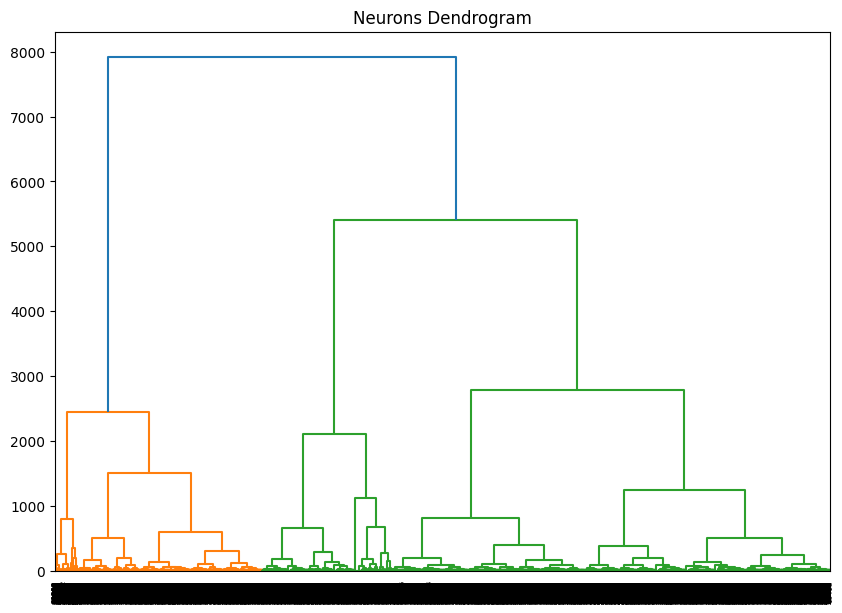

In [53]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

# Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward')
clustering.fit(acts)

# Plotting the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Neurons Dendrogram")
Z = sch.linkage(acts, method='ward')
dendrogram = sch.dendrogram(Z)
plt.show()

In [ ]:
distance_threshold = 6_000
clusters = fcluster(Z, distance_threshold, criterion='distance')

## Residual stream low density direction

In [ ]:
# Calculate mean residual direction of low density features
# Take random residual directions of normal features
# Calculate norm of residual directions over a bunch of examples
# Compare if low density direction is outlier

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# There are many features in low density cluster
# Do they generally co-fire?
# are there firing clusters?
def save_activation(value, hook):
    hook.ctx['activation'] = value

acts = []
for prompt in prompts[:200]:
    with model.hooks([("blocks.0.mlp.hook_post", save_activation)]):
        model(prompt)
        all_acts = model.hook_dict["blocks.0.mlp.hook_post"].ctx["activation"][0]
        dir_acts = einops.einsum(all_acts, encoder.W_enc[:, directions], "pos d_mlp, d_mlp d_interesting -> pos d_interesting")
        acts.append(dir_acts.cpu())

acts = torch.cat(acts, dim=0) # along token dim
print(acts.shape)

torch.Size([38589, 703])


In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward')
clustering.fit(acts)

# Plotting the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Neurons Dendrogram")
dendrogram = sch.dendrogram(sch.linkage(acts, method='ward'))
plt.show()

(INFO) 11:08:01: generated new fontManager


In [ ]:
# do a run with the best found config so far and a ReLU 98_hardy_firefly